# Load data

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# Import Resnet Models

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from resnet import ResNet18

In [4]:
# Select device
# device = torch.device('cuda')
device = torch.device('cpu')

## Import Resnet model

In [5]:
# Check for model
if os.path.isfile('cifar resnet.pt'):
    # Load saved model
    print('Loading saved model')
    model_resnet = torch.load('cifar resnet.pt').to(device)
else:
    print('Model not available')

Loading saved model


## Import surrogate

In [6]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [7]:
# Check for model
if os.path.isfile('cifar surrogate.pt'):
    print('Loading saved surrogate model')
    surr = torch.load('cifar surrogate.pt').to(device)
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

else:
    print('Model not available')

Loading saved surrogate model


## Import Explainer

In [8]:
from unet import UNet
from fastshap import FastSHAP

In [9]:
# Check for model
if os.path.isfile('cifar explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('cifar explainer.pt').to(device)
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

else:
    print('Model not available')

Loading saved explainer model


# Initialize dataset

In [100]:
dset = val_set
# dset_size = 10000
dset_size = 20
targets = np.array(dset.targets)
num_classes = targets.max() + 1
classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Plot individual images and values

In [101]:
import matplotlib.pyplot as plt

In [102]:
def plot_img(x):
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x.numpy() * std + mean    
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    plt.imshow(im, vmin=0, vmax=1)
    plt.show()

In [103]:
def plot_values(value):
#     plt.imshow(value, cmap='seismic',vmin=-m, vmax=m )
    plt.imshow(value, cmap='seismic')

# Collect performance results Using Resnet

## Create dataframe to store results

In [104]:
import pandas as pd
import numpy as np

In [105]:
columns =  ['y_label','y_resnet_class', 'y_resnet_prob', 'resnet_correct']
dset_idxs = np.array(range(dset_size))
results = pd.DataFrame(columns = columns, index = dset_idxs)

In [106]:
results.head()

,y_label,y_resnet_class,y_resnet_prob,resnet_correct
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


## Collect data 

In [107]:
for idx in range(dset_size):
    x, y = zip(*[dset[idx]])
    x = torch.stack(x)
    y = y[0]
    y_pred = model_resnet(x).softmax(dim=1).detach()
    y_pred_class = np.argmax(y_pred)
    
    # store values
    results.iloc[idx]['y_label'] = y
    results.iloc[idx]['y_resnet_class'] = y_pred_class.item()
    results.iloc[idx]['y_resnet_prob'] = y_pred[0][y_pred_class.item()].item()
    if (y == y_pred_class): 
        results.iloc[idx]['resnet_correct'] = 1
    else:
         results.iloc[idx]['resnet_correct'] = 0


In [108]:
y_pred[0][3]

tensor(0.0445)

In [110]:
results.head(10)

,y_label,y_resnet_class,y_resnet_prob,resnet_correct
0,3,3,0.366576,1
1,8,8,0.307475,1
2,8,1,0.241541,0
3,0,1,0.37162,0
4,6,1,0.321299,0
5,6,1,0.551747,0
6,1,1,0.407426,1
7,6,5,0.264785,0
8,3,1,0.233738,0
9,1,1,0.523663,1


In [112]:
wrong_results = results[results['resnet_correct'] == 0]

In [113]:
wrong_results

,y_label,y_resnet_class,y_resnet_prob,resnet_correct
2,8,1,0.241541,0
3,0,1,0.37162,0
4,6,1,0.321299,0
5,6,1,0.551747,0
7,6,5,0.264785,0
8,3,1,0.233738,0
10,0,1,0.239549,0
13,7,9,0.243251,0
15,8,1,0.310444,0
16,5,1,0.219672,0


In [136]:
def check_results(idx,  results):
    x, y = zip(*[dset[idx]])
    x = x[0]
    y = y[0]
    print(f'Label = {classes[y]}, {y}')
    y_predicted = results.iloc[idx]['y_resnet_class'] 
    print(f'Predicted = {classes[y_predicted]} , {y_predicted}' )
    plot_img(x)

Label = Horse, 7
Predicted = Truck , 9


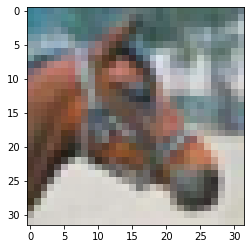

In [140]:
idx = 17
check_results(idx, results)